# NBA Game Prediction: Modelling Matchups
Written by Nicholas Cannon

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, KBinsDiscretizer, MinMaxScaler
)

from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay, precision_recall_curve,
    PrecisionRecallDisplay
)

%matplotlib inline

DATA_DIR = os.path.join('..', 'data', 'processed', 'games')
STATE = 0
os.environ['PYTHONHASHSEED'] = str(STATE)

In [92]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    FROM: https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def run_metrics(y_pred, y_true, y_score):
    """Display Standard graphs and metrics for model evaluation"""
    fig, ax = plt.subplots(1, 3, figsize=(10, 8), constrained_layout=True)
    
    # CF Matrix
    for i in [0, 1]:        
        cf_data = confusion_matrix(y_true[i], y_pred[i], normalize='all') * 100
        im = ax[i].imshow(cf_data, cmap=plt.cm.Blues) 
        ax[i].set_xticks(np.arange(cf_data.shape[1]))
        ax[i].set_yticks(np.arange(cf_data.shape[0]))
        ax[i].set_xticklabels(['Home Lose', 'Home Win'])
        ax[i].set_yticklabels(['Home Lose', 'Home Win'], rotation=90, va='center')
        ax[i].set_title('Adv.' if i == 0 else 'Trad.')
        annotate_heatmap(im, valfmt="{x:.2f} %")

    # ROC Curve
    fpr_1, tpr_1, _ = roc_curve(y_true[0], y_score[0])
    auc_1 = auc(fpr_1, tpr_1)
    fpr_2, tpr_2, _ = roc_curve(y_true[1], y_score[1])
    auc_2 = auc(fpr_2, tpr_2)
    
    ax[2].set_xlim((0, 1))
    ax[2].set_ylim((0, 1))
    ax[2].set_aspect('equal', 'box')
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    
    ax[2].plot(fpr_1, tpr_1, label='Adv. (AUC={:.2f})'.format(auc_1))
    ax[2].plot(fpr_2, tpr_2, label='Trad. (AUC={:.2f})'.format(auc_2))
    ax[2].legend(loc='lower right')
    
    plt.show()
    return fig


def load_season(season):
    """Load season data and apply basic preprocessing"""
    df = pd.read_csv(os.path.join(DATA_DIR, season))
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.sort_values('DATE', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


def get_matchup_games(df, team1, team2):
    """Return all games played between both teams"""
    df1 = df[(df['H_ID'] == team1) ^ (df['A_ID'] == team1)]
    df2 = df[(df['H_ID'] == team2) ^ (df['A_ID'] == team2)]
    games = pd.merge(df1, df2, on='GAME_ID')['GAME_ID']

    return df[df['GAME_ID'].isin(games)]

In [4]:
class ProcessFeatures(BaseEstimator):
    
    def __init__(self, avg_cols, return_df=False, window=5):
        self.team_enc = OneHotEncoder(sparse=False)
        self.return_df = return_df
        self.window = window
        self.avg_cols = avg_cols
    
    def fit(self, X, y=None):
        self._check_df(X)
        self.team_enc.fit(X[['H_ID', 'A_ID']])
        self.t_cols = [
            *('{}_h'.format(idx) for idx in self.team_enc.categories_[0]),
            *('{}_a'.format(idx) for idx in self.team_enc.categories_[1])
        ]
        
        return self
    
    def transform(self, X):
        self._check_df(X)
        X = X.copy() # make a copy to prevent changes being made
        
        # compute features
        h_won_last = X.apply(self._home_won_last, args=[{}], axis=1)
        h_leader = X.apply(self._home_series_leader, args=[defaultdict(list)], axis=1)
        teams = self.team_enc.transform(X[['H_ID', 'A_ID']])
        teams = pd.DataFrame(data=teams, columns=self.t_cols)
        
        # compute feature averages for home / away teams
        h_avgs = (
            X.groupby('H_ID')
                [['H_{}'.format(col) for col in self.avg_cols]]
                .rolling(self.window).mean()  # Compute rolling mean
                .groupby('H_ID')              # Group by H_ID again
                .shift(1)                     # Ensure avg is from prev game
                .droplevel(0)                 # drop top level index (H_ID)
                .sort_index()
        )
        a_avgs = (
            X.groupby('A_ID')
                [['A_{}'.format(col) for col in self.avg_cols]]
                .rolling(self.window).mean()  # Compute rolling mean
                .groupby('A_ID')              # Group by A_ID again
                .shift(1)                     # Ensure avg is from prev game
                .droplevel(0)                 # drop top level index (A_ID)
                .sort_index()
        )

        # compute differential stats and rename
        diff = a_avgs - h_avgs.values
        diff.columns = self.avg_cols
        
        # combine all features
        data = pd.concat([
            diff,
            h_won_last.rename('H_WON_LAST'),
            h_leader.rename('H_LEADER'),
            teams,
            X[['HOME_WIN']]
        ], axis=1)
        self.columns = data.columns
        
        if self.return_df:
            return data
        else:
            return data.dropna().values
        
    def fit_transform(self, X, y=None):
        self._check_df(X)
        return self.fit(X).transform(X)
    
    def _check_df(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError('X must be a pandas DataFrame')
            
    """PANDAS TRANSFORMATION METHODS"""
    
    @classmethod
    def _home_series_leader(cls, row, series_history):
        """Computes whether or not the home team is the series leader"""
        matchup_id = tuple(sorted([row['H_ID'], row['A_ID']]))

        # get series history, count wins and which team is the leader
        series = series_history.get(matchup_id, None)
        if series is None:
            home_leader = 1
        else:
            home_leader = int(series.count(row['H_ID']) >= series.count(row['A_ID']))

        # add game winner to series history
        series_history[matchup_id].append(row['H_ID'] if row['HOME_WIN'] else row['A_ID'])
        return home_leader
    
    @classmethod 
    def _home_won_last(cls, row, last_games):
        """Computes whether or not the home team won the last matchup. """
        matchup_id = tuple(sorted([row['H_ID'], row['A_ID']]))

        # get winner of previous game, if no game exists pick home team
        last_winner = last_games.get(matchup_id, None)
        if last_winner is None:
            home_won = 1
        else:
            home_won = 1 if row['H_ID'] == last_winner else 0

        # update last game for this matchup
        last_games[matchup_id] = row['H_ID'] if row['HOME_WIN'] else row['A_ID']
        return home_won

In [5]:
# adv_cols = ['DEF_RATING', 'OFF_RATING', 'TS_PCT', 'EFG_PCT',
#             'PASS', 'PACE', 'TCHS', 'TM_TOV_PCT', 'CFGM', 
#            'CFGA', 'UFGM', 'UFGA', 'DIST']

# tester = load_season('2018-full.csv')
# pf_t = ProcessFeatures(adv_cols)
# pf_t = pf_t.fit_transform(tester)
# pf_t.shape

# Baseline Models

In [61]:
df_test = load_season('2018-full.csv')
df_test['HOME_WIN'].value_counts()

1    729
0    501
Name: HOME_WIN, dtype: int64

## Always pick home team

In [62]:
y_home = np.ones((df_test.shape[0],))
print('F1 =', f1_score(df_test['HOME_WIN'], y_home, average='weighted'))

F1 = 0.44110857953908783


## Always pick the team who won last matchup
Pick the team who won the last matchup, if no previous matchup exists pick the home team.

In [63]:
df_test['H_WON_LAST'] = df_test.apply(ProcessFeatures._home_won_last, args=[{}], axis=1)
y_last_win = df_test['H_WON_LAST']
print('F1 =', f1_score(df_test['HOME_WIN'], y_last_win, average='weighted'))
    
# Feature validation
# matchup = get_matchup_games(df, 1610612739, 1610612766)
# matchup[['A_ID', 'H_ID', 'HOME_WIN', 'H_WON_LAST']]

F1 = 0.5387556943017995


## Always pick the series leader
Pick Home team if the series is tied

In [64]:
df_test['H_LEADER'] = df_test.apply(ProcessFeatures._home_series_leader, args=[defaultdict(list)], axis=1)
y_series_leader = df_test['H_LEADER']
print('F1 =', f1_score(df_test['HOME_WIN'], y_series_leader, average='weighted'))

# Feature validation
# matchup = get_matchup_games(df, 1610612739, 1610612766)
# matchup[['A_ID', 'H_ID', 'HOME_WIN', 'H_LEADER']]

F1 = 0.5605965466967578


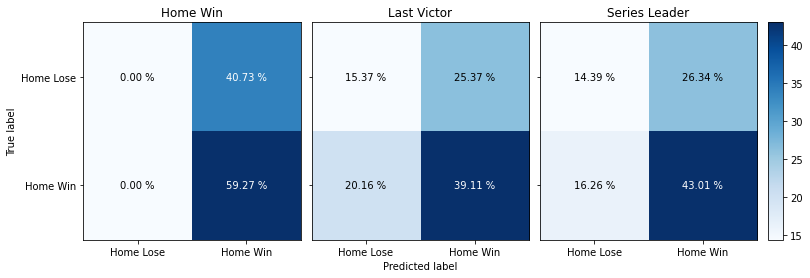

In [71]:
import itertools
from mpl_toolkits.axes_grid1 import ImageGrid


classes = ['Home Lose', 'Home Win']

fig = plt.figure(figsize=(17, 4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)

cfs = [
    confusion_matrix(df_test['HOME_WIN'], y_home, normalize='all') * 100,
    confusion_matrix(df_test['HOME_WIN'], y_last_win, normalize='all') * 100,
    confusion_matrix(df_test['HOME_WIN'], y_series_leader, normalize='all') * 100
]
titles = ['Home Win', 'Last Victor', 'Series Leader']

for i, (ax, cf) in enumerate(zip(grid[:3], cfs)):
    cm = cf
    im = ax.imshow(cm, cmap='Blues')
    tick_marks = np.arange(2)
    ax.set_title(titles[i])
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    annotate_heatmap(im, valfmt="{x:.2f} %")
    
    ax.set_ylabel('True label')
    if i == 1: 
        ax.set_xlabel('Predicted label')


fig.colorbar(im, cax=ax.cax)
plt.show()
fig.savefig('plots/baseline-results.pdf', bbox_inches='tight')

## Data Prep

In [6]:
# load training data
df_train = load_season('2017-full.csv')
df_test = pd.concat([
    df_train, # rolls data into 2018 season
    load_season('2018-full.csv')
], ignore_index=True)

adv_cols = ['DEF_RATING', 'OFF_RATING', 'TS_PCT', 'EFG_PCT',
            'PASS', 'PACE', 'TCHS', 'TM_TOV_PCT', 'CFGM', 
           'CFGA', 'UFGM', 'UFGA', 'DIST']
trad_cols = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 
             'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MIN']


# ADVANCED FEATURES
pf = ProcessFeatures(adv_cols, return_df=True)
df_train_adv = pf.fit_transform(df_train)
df_test_adv = pf.transform(df_test)

# convert to numpy and drop training data from test
df_train_adv = df_train_adv.dropna().values
df_test_adv = df_test_adv[1230:].values # IMPORTANT!!

# split features and labels
X_train_adv, y_train_adv = df_train_adv[:, :-1], df_train_adv[:, -1]
X_test_adv, y_test_adv = df_test_adv[:, :-1], df_test_adv[:, -1]

In [7]:
# TRADITIONAL FEATURES
pf_trad = ProcessFeatures(trad_cols, return_df=True)
df_train_trad = pf_trad.fit_transform(df_train)
df_test_trad = pf_trad.transform(df_test)

# convert to numpy and drop training data from test
df_train_trad = df_train_trad.dropna().values
df_test_trad = df_test_trad[1230:].values # IMPORTANT!!

# split features and labels
X_train_trad, y_train_trad = df_train_trad[:, :-1], df_train_trad[:, -1]
X_test_trad, y_test_trad = df_test_trad[:, :-1], df_test_trad[:, -1]

# Linear Regression Model

In [8]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=STATE)
lr_params = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [1.0, 0.8, 0.5]
}

clf_1 = GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, scoring='f1', n_jobs=-1)
clf_1.fit(X_train_adv, y_train_adv)
clf_1.best_params_

{'C': 0.8, 'penalty': 'l1'}

In [9]:
y_score_1 = clf_1.predict_proba(X_test_adv)
y_pred_1 = (y_score_1[:, 1] >= 0.5).astype(int)

print('F1 =', f1_score(y_test_adv, y_pred_1, average='weighted'))
print('Accuracy =', clf_1.score(X_test_adv, y_test_adv))

F1 = 0.6356166110733178
Accuracy = 0.6686217008797654


## Using only traditional stats

In [10]:
clf_2 = GridSearchCV(estimator=lr, param_grid=lr_params, scoring='f1', cv=5, n_jobs=-1)
clf_2.fit(X_train_trad, y_train_trad)
clf_2.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [11]:
y_score_2 = clf_2.predict_proba(X_test_trad)
y_pred_2 = (y_score_2[:, 1] >= 0.5).astype(int)

print('F1 =', f1_score(y_test_trad, y_pred_2, average='weighted'))
print('Accuracy =', clf_2.score(X_test_trad, y_test_trad))

F1 = 0.6209205449112458
Accuracy = 0.6589259796806967


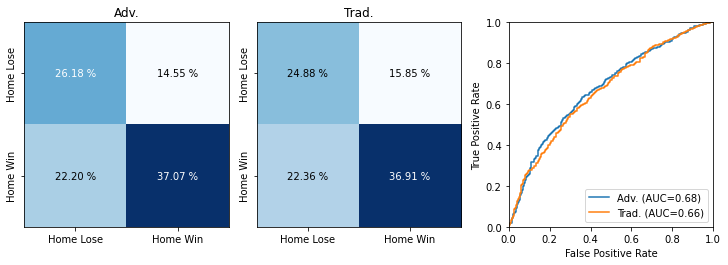

In [72]:
fig = run_metrics(
    [y_pred_1, y_pred_2], 
    [y_test_adv, y_test_trad], 
    [y_score_1[:, 1], y_score_2[:, 1]]
)
fig.savefig('plots/matchups-LR.pdf', bbox_inches='tight')

# Random Forest

In [73]:
rf = RandomForestClassifier(class_weight='balanced', random_state=STATE)
rf_params = {
    'n_estimators': [300, 500],
    'min_samples_leaf': [1, 3]
}

# make copies for binning
X_train_adv_binned = X_train_adv.copy()
X_test_adv_binned = X_test_adv.copy()

# discretize continuous features!!
kbins = KBinsDiscretizer(encode='ordinal', strategy='kmeans', n_bins=3)
X_train_adv_binned[:, :len(pf.avg_cols)] = kbins.fit_transform(X_train_adv[:, :len(pf.avg_cols)])
X_test_adv_binned[:, :len(pf.avg_cols)] = kbins.transform(X_test_adv[:, :len(pf.avg_cols)])

clf_3 = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='f1', n_jobs=-1)
clf_3.fit(X_train_adv_binned, y_train_adv)
clf_3.best_params_

{'min_samples_leaf': 1, 'n_estimators': 500}

In [74]:
y_score_3 = clf_3.predict_proba(X_test_adv_binned)
y_pred_3 = (y_score_3[:, 1] >= 0.5).astype(int)

print('F1 =', f1_score(y_test_adv, y_pred_3, average='weighted'))
print('Accuracy =', clf_3.score(X_test_adv_binned, y_test_adv))

F1 = 0.6128084968035005
Accuracy = 0.6902423051735429


### Feature Importances!!

In [75]:
f_imp_idx = list(reversed(np.argsort(clf_3.best_estimator_.feature_importances_)))[:10]
f_imp_sorted = sorted(clf_3.best_estimator_.feature_importances_, reverse=True)[:10]

for feature, importance in zip(pf.columns[f_imp_idx], f_imp_sorted):
    print(feature, importance)

OFF_RATING 0.046464833955991644
DEF_RATING 0.04423731909131417
TM_TOV_PCT 0.040050770315290016
PACE 0.03933802177655433
CFGM 0.03625750512606446
UFGA 0.03561462534681647
CFGA 0.03486771546931186
EFG_PCT 0.033132734561824896
UFGM 0.03303701332744865
TS_PCT 0.03248363735723976


## Using only traditional stats

In [76]:
# make copies for binning
X_train_trad_binned = X_train_trad.copy()
X_test_trad_binned = X_test_trad.copy()

# discretize continuous features!!
kbins = KBinsDiscretizer(encode='ordinal', strategy='kmeans', n_bins=3)
X_train_trad_binned[:, :len(pf_trad.avg_cols)] = kbins.fit_transform(X_train_trad[:, :len(pf_trad.avg_cols)])
X_test_trad_binned[:, :len(pf_trad.avg_cols)] = kbins.transform(X_test_trad[:, :len(pf_trad.avg_cols)])

clf_4 = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='f1', n_jobs=-1)
clf_4.fit(X_train_trad_binned, y_train_trad)
clf_4.best_params_

{'min_samples_leaf': 1, 'n_estimators': 500}

In [77]:
y_score_4 = clf_4.predict_proba(X_test_trad_binned)
y_pred_4 = (y_score_4[:, 1] >= 0.5).astype(int)

print('F1 =', f1_score(y_test_trad, y_pred_4, average='weighted'))
print('Accuracy =', clf_4.score(X_test_trad_binned, y_test_trad))

F1 = 0.6257905139040166
Accuracy = 0.7064160725858716


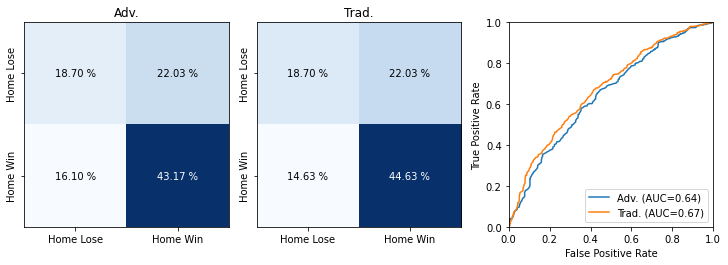

In [78]:
fig = run_metrics(
    [y_pred_3, y_pred_4], 
    [y_test_adv, y_test_trad], 
    [y_score_3[:, 1], y_score_4[:, 1]]
)
fig.savefig('plots/matchups-RF.pdf', bbox_inches='tight')

### Feature Importances (traditional stats)

In [79]:
f_imp_idx_2 = list(reversed(np.argsort(clf_4.best_estimator_.feature_importances_)))[:10]
f_imp_sorted_2 = sorted(clf_4.best_estimator_.feature_importances_, reverse=True)[:10]

for feature, importance in zip(pf_trad.columns[f_imp_idx_2], f_imp_sorted_2):
    print(feature, importance)

PLUS_MIN 0.06107602161227703
PTS 0.04233080391169445
FT_PCT 0.03889565370711701
OREB 0.03855557656293828
FG_PCT 0.03845345479147442
STL 0.03843344497721894
BLK 0.03826945961800123
FG3_PCT 0.037679683782516626
TO 0.037597542266329394
PF 0.03758768073025304


# Neural Net

In [121]:
from tensorflow import keras
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import random

K = keras.backend

# allow reproducible results
random.seed(STATE)
np.random.seed(STATE)
tf.random.set_seed(STATE)


def f1(y_true, y_pred):
    """Use keras backend to compute f1 metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [122]:
# scale data between 0 and 1
mm_scaler = MinMaxScaler()
X_train_adv_s = mm_scaler.fit_transform(X_train_adv)
X_test_adv_s = mm_scaler.transform(X_test_adv)

# create a validation set from test set
X_train_adv_s, X_val_adv_s, y_train_adv_s, y_val_adv_s = train_test_split(X_train_adv_s, y_train_adv,
                                                                          test_size=0.1,
                                                                          random_state=STATE)

class_weights_1 = compute_class_weight('balanced', classes=np.unique(y_train_adv_s), 
                                     y=y_train_adv_s)
class_weights_1 = {
    0: class_weights_1[0],
    1: class_weights_1[1],
}
X_train_adv_s.shape[1]

75

In [132]:
ann_1 = keras.models.Sequential([
    keras.layers.Input(shape=(X_train_adv_s.shape[1],)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(16, activation='selu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(8, activation='selu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(1, activation='sigmoid'),
])

# METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'), f1]
METRICS = [f1]
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
adam = keras.optimizers.Adam(learning_rate=0.001, decay=1e-4)

ann_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=METRICS)

In [133]:
ann1_hist = ann_1.fit(X_train_adv_s, y_train_adv_s, epochs=100, 
          validation_data=(X_val_adv_s, y_val_adv_s), 
          callbacks=[early_stop], class_weight=class_weights_1)

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 0.7503 - f1: 0.5851 - val_loss: 0.6497 - val_f1: 0.7562
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 0.7145 - f1: 0.5920 - val_loss: 0.6379 - val_f1: 0.7452
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6919 - f1: 0.6303 - val_loss: 0.6345 - val_f1: 0.6773
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6536 - f1: 0.6508 - val_loss: 0.6321 - val_f1: 0.6634
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6525 - f1: 0.6470 - val_loss: 0.6275 - val_f1: 0.6474
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6356 - f1: 0.6557 - val_loss: 0.6184 - val_f1: 0.6710
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6356 - f1: 0.6714 - val_loss: 0.6154 - val_f1: 0.6667
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6276 - f1: 0.6784 - va

In [134]:
ann_1_score = ann_1.predict(X_test_adv_s)
ann_1_pred = (ann_1_score > 0.5).astype(int)

print('F1 =', f1_score(y_test_adv, ann_1_pred, average='weighted'))
print('Accuracy =', accuracy_score(ann_1_pred, y_test_adv))

F1 = 0.6201622528533621
Accuracy = 0.6170731707317073


## Using Traditional Stats

In [140]:
# scale data between 0 and 1
mm_scaler_2 = MinMaxScaler()
X_train_trad_s = mm_scaler_2.fit_transform(X_train_trad)
X_test_trad_s = mm_scaler_2.transform(X_test_trad)

# create a validation set from test set
X_train_trad_s, X_val_trad_s, y_train_trad_s, y_val_trad_s = train_test_split(X_train_trad_s, y_train_trad,
                                                                              test_size=0.1,
                                                                              random_state=STATE)

class_weights_2 = compute_class_weight('balanced', classes=np.unique(y_train_trad_s), 
                                     y=y_train_trad_s)
class_weights_2 = {
    0: class_weights_2[0],
    1: class_weights_2[1],
}

In [141]:
ann_2 = keras.models.Sequential([
    keras.layers.Input(shape=(X_train_trad_s.shape[1],)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(16, activation='selu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(8, activation='selu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(1, activation='sigmoid'),
])

METRICS = [f1]
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
adam = keras.optimizers.Adam(learning_rate=0.001, decay=1e-4)

ann_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=METRICS)

In [142]:
ann2_hist = ann_2.fit(X_train_trad_s, y_train_trad_s, epochs=100, 
          validation_data=(X_val_trad_s, y_val_trad_s), 
          callbacks=[early_stop], class_weight=class_weights_2)

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 0.8176 - f1: 0.5380 - val_loss: 0.6915 - val_f1: 0.7122
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 0.7638 - f1: 0.5550 - val_loss: 0.6927 - val_f1: 0.6095
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6984 - f1: 0.5900 - val_loss: 0.6952 - val_f1: 0.6014
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6626 - f1: 0.6367 - val_loss: 0.6955 - val_f1: 0.4667
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6701 - f1: 0.6506 - val_loss: 0.6993 - val_f1: 0.4507
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6607 - f1: 0.6383 - val_loss: 0.6912 - val_f1: 0.4582
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6460 - f1: 0.6523 - val_loss: 0.6874 - val_f1: 0.4865
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6354 - f1: 0.6705 - va

In [143]:
ann_2_score = ann_2.predict(X_test_trad_s)
ann_2_pred = (ann_2_score > 0.5).astype(int)

print('F1 =', f1_score(y_test_trad, ann_2_pred, average='weighted'))
print('Accuracy =', accuracy_score(ann_2_pred, y_test_trad))

F1 = 0.6026601210750134
Accuracy = 0.5991869918699188


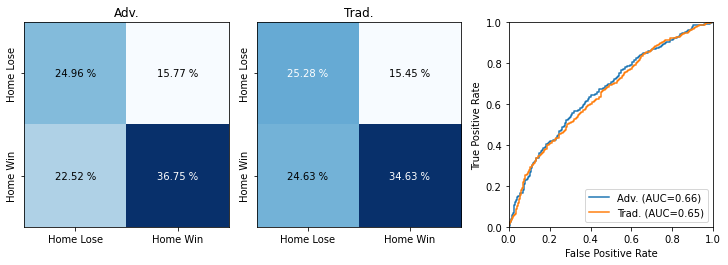

In [146]:
fig = run_metrics(
    [ann_1_pred, ann_2_pred], 
    [y_test_adv, y_test_trad], 
    [ann_1_score, ann_2_score]
)
fig.savefig('plots/matchups-NN.pdf', bbox_inches='tight')

In [145]:
import pickle
pickle.dump(ann1_hist.history, open('ann1_hist.pickle', 'wb'))
pickle.dump(ann2_hist.history, open('ann2_hist.pickle', 'wb'))

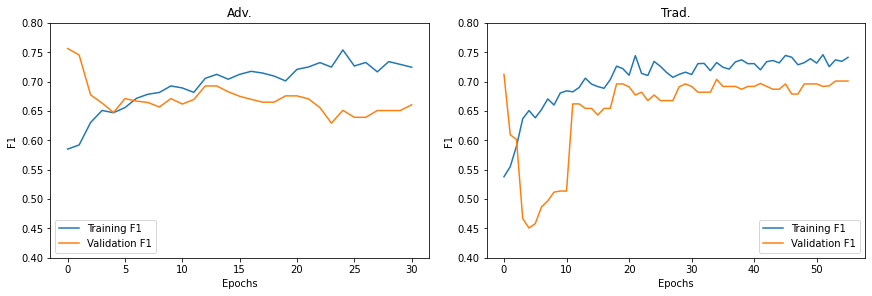

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

ax[0].plot(ann1_hist.history['f1'])
ax[0].plot(ann1_hist.history['val_f1'])
ax[0].legend(['Training F1', 'Validation F1'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('F1')
ax[0].set_ylim((0.4, 0.8))
ax[0].set_title('Adv.')

ax[1].plot(ann2_hist.history['f1'])
ax[1].plot(ann2_hist.history['val_f1'])
ax[1].legend(['Training F1', 'Validation F1'], loc='lower right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('F1')
ax[1].set_ylim((0.4, 0.8))
ax[1].set_title('Trad.')

fig.savefig('plots/matchups-NN-curves.pdf', bbox_inches='tight')